# Learning the structure of a Bayesian network

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

In [1]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

import os

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.explain as explain
import pyAgrum.lib.bn_vs_bn as bnvsbn

gum.about()
gnb.configuration()


pyAgrum 1.4.1.9
(c) 2015-2022 Pierre-Henri Wuillemin, Christophe Gonzales

    This is free software; see the source code for copying conditions.
    There is ABSOLUTELY NO WARRANTY; not even for MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  For details, see 'pyAgrum.warranty'.
    


Library,Version
OS,nt [win32]
Python,"3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]"
IPython,8.6.0
Matplotlib,3.6.2
Numpy,1.23.4
pyDot,1.4.2
pyAgrum,1.4.1.9


## Generating the database from a BN

In [3]:
bn=gum.loadBN("res/asia.bif")
bn

(pyAgrum.BayesNet<double>@000001C11D985010) BN{nodes: 8, arcs: 8, domainSize: 256, dim: 18, mem: 288o}

In [4]:
gum.generateSample(bn,500000,"out/sample_asia.csv",True);

out/sample_asia.csv: 100%|█████████████████████████████████|


Log2-Likelihood : -1612515.0955120972


In [5]:
with open("out/sample_asia.csv","r") as src:
    for _ in range(10):
        print(src.readline(),end="")

smoking,visit_to_Asia,lung_cancer,bronchitis,tuberculos_or_cancer,dyspnoea,positive_XraY,tuberculosis
0,1,1,0,1,0,1,1
0,1,1,1,1,1,1,1
0,1,0,0,0,0,0,1
1,1,1,1,1,1,1,1
1,1,1,1,1,0,1,1
0,1,1,0,1,0,1,1
0,1,1,0,1,0,1,1
1,1,1,1,1,0,1,1
0,1,1,1,1,0,1,1


In [6]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
print(learner)


Filename       : out/sample_asia.csv
Size           : (500000,8)
Variables      : visit_to_Asia[2], tuberculosis[2], tuberculos_or_cancer[2], positive_XraY[2], lung_cancer[2], smoking[2], bronchitis[2], dyspnoea[2]
Induced types  : False
Missing values : False
Algorithm      : Greedy Hill Climbing
Score          : BDeu
Prior          : -



In [7]:
print(f"Row of visit_to_Asia : {learner.idFromName('visit_to_Asia')}") # first row is 0

Row of visit_to_Asia : 0


In [8]:
print(f"Variable in row 4 : {learner.nameFromId(4)}")

Variable in row 4 : lung_cancer


The BNLearner is capable of recognizing missing values in databases. For this purpose, just indicate as a last argument the list of the strings that represent missing values.

In [9]:
# it is possible to add as a last argument a list of the symbols that represent missing values:
# whenever a cell of the database is equal to one of these strings, it is considered as a
# missing value
learner=gum.BNLearner("res/asia_missing.csv",bn, ['?', 'N/A'] )
print(f"Are there missing values in the database ? {learner.state()['Missing values'][0]}")

Are there missing values in the database ? True


### type induction

When reading a csv file, BNLearner can try to find the correct type for discrete variable. Especially for numeric values.

In [10]:
%%writefile out/testTypeInduction.csv
A,B,C,D
1,2,0,hot
0,3,-2,cold
0,1,2,hot
1,2,2,warm

Overwriting out/testTypeInduction.csv


In [11]:
print("* by default, type induction is on (True) :")
learner=gum.BNLearner("out/testTypeInduction.csv")
bn3=learner.learnBN()
for v in sorted(bn3.names()):
    print(f"  - {bn3.variable(v)}")

print("")
print("* but you can disable it :")
learner=gum.BNLearner("out/testTypeInduction.csv",["?"],False)
bn3=learner.learnBN()
for v in sorted(bn3.names()):
    print(f"  - {bn3.variable(v)}")

print("")
print("Note that when a Labelized variable is found, the labesl are alphabetically sorted.")

* by default, type induction is on (True) :
  - A:Range([0,1])
  - B:Range([1,3])
  - C:Integer({-2|0|2})
  - D:Labelized({cold|hot|warm})

* but you can disable it :
  - A:Labelized({0|1})
  - B:Labelized({1|2|3})
  - C:Labelized({-2|0|2})
  - D:Labelized({cold|hot|warm})

Note that when a Labelized variable is found, the labesl are alphabetically sorted.


## Parameters learning from the database

We give the $bn$ as a parameter for the learner in order to have the variables and the order of the labels for each variables. Please try to remove the argument $bn$ in the first line below to see the difference ...

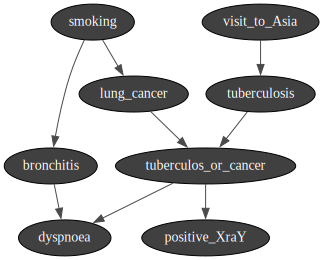

In [12]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables and labels
bn2=learner.learnParameters(bn.dag())
gnb.showBN(bn2)

In [13]:
from IPython.display import HTML

gnb.sideBySide("<H3>Original BN</H3>","<H3>Learned NB</H3>",
               bn.cpt ('visit_to_Asia'),bn2.cpt ('visit_to_Asia'),
               bn.cpt ('tuberculosis'),bn2.cpt ('tuberculosis'),
               ncols=2)


## Structural learning a BN from the database

Note that, currently, the BNLearner is not yet able to learn in the presence of missing values. This is the reason why, when it discovers that there exist such values, it raises a gum.MissingValueInDatabase exception.

In [14]:
with open("res/asia_missing.csv","r") as asiafile:
    for _ in range(10):
        print(asiafile.readline(),end="")
try:
    learner=gum.BNLearner("res/asia_missing.csv",bn, ['?', 'N/A'] )
    bn2=learner.learnBN()
except gum.MissingValueInDatabase:
    print ( "exception raised: there are missing values in the database" )

smoking,lung_cancer,bronchitis,visit_to_Asia,tuberculosis,tuberculos_or_cancer,dyspnoea,positive_XraY
0,0,0,1,1,0,0,0
1,1,0,1,1,1,0,1
1,1,1,1,1,1,1,1
1,1,0,1,1,1,0,N/A
0,1,0,1,1,1,1,1
1,1,1,1,1,1,1,1
1,1,1,1,1,1,0,1
1,1,0,1,1,1,0,1
1,1,1,1,1,1,1,1
exception raised: there are missing values in the database


### Different learning algorithms

For now, there are three algorithms that are wrapped in pyAgrum : LocalSearchWithTabuList,

In [15]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useLocalSearchWithTabuList()
print(learner)
bn2=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
gnb.flow.row(bn,bn2,explain.getInformation(bn2),captions=["Original BN","Learned BN","information"])

Filename       : out/sample_asia.csv
Size           : (500000,8)
Variables      : visit_to_Asia[2], tuberculosis[2], tuberculos_or_cancer[2], positive_XraY[2], lung_cancer[2], smoking[2], bronchitis[2], dyspnoea[2]
Induced types  : False
Missing values : False
Algorithm      : Local Search with Tabu List
Tabu list size : 2
Score          : BDeu
Prior          : -

Learned in 157.321ms


To apprehend the distance between the original and the learned BN, we have several tools :
- Compute the KL divergence (and other distance) between original and learned joint distribution

In [16]:
kl=gum.ExactBNdistance(bn,bn2)
kl.compute()

{'klPQ': 3.5266438773301774e-05,
 'errorPQ': 0,
 'klQP': 3.208956590620902e-05,
 'errorQP': 128,
 'hellinger': 0.0035595333108700325,
 'bhattacharya': 6.32951686089867e-06,
 'jensen-shannon': 8.917153960840678e-06}

- Compute some scores on the BNs (as binary classifiers) abd show the graphical diff between the two graphs

In [17]:
gcmp=bnvsbn.GraphicalBNComparator(bn,bn2)
gnb.flow.add(bnvsbn.graphDiff(bn,bn2))
gnb.flow.add(bnvsbn.graphDiffLegend())
gnb.flow.new_line()
gnb.flow.add_html("<br/>".join([f"{k} : {v:.2f}" for k,v in gcmp.skeletonScores().items() if k!='count']),"Skeleton scores")
gnb.flow.add_html("<br/>".join([f"{k} : {v:.2f}" for k,v in gcmp.scores().items() if k!='count']),"Scores")

gnb.flow.display()

A greedy Hill Climbing algorithm (with insert, remove and change arc as atomic operations).

In [18]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useGreedyHillClimbing()
print(learner)
bn2=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
gnb.sideBySide(bn,bn2,gnb.getBNDiff(bn,bn2),explain.getInformation(bn2),captions=["Original BN","Learned BN","Graphical diff","information"])

Filename       : out/sample_asia.csv
Size           : (500000,8)
Variables      : visit_to_Asia[2], tuberculosis[2], tuberculos_or_cancer[2], positive_XraY[2], lung_cancer[2], smoking[2], bronchitis[2], dyspnoea[2]
Induced types  : False
Missing values : False
Algorithm      : Greedy Hill Climbing
Score          : BDeu
Prior          : -

Learned in 97.3961ms


And a K2 for those who likes it :)

In [19]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useK2([0,1,2,3,4,5,6,7])
print(learner)
bn2=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
gnb.sideBySide(bn,bn2,gnb.getBNDiff(bn,bn2),explain.getInformation(bn2),captions=["Original BN","Learned BN","Graphical diff","information"])

Filename       : out/sample_asia.csv
Size           : (500000,8)
Variables      : visit_to_Asia[2], tuberculosis[2], tuberculos_or_cancer[2], positive_XraY[2], lung_cancer[2], smoking[2], bronchitis[2], dyspnoea[2]
Induced types  : False
Missing values : False
Algorithm      : K2
K2 order       : visit_to_Asia, tuberculosis, tuberculos_or_cancer, positive_XraY, lung_cancer, smoking, bronchitis, dyspnoea
Score          : BDeu
Prior          : -

Learned in 46.3559ms


K2 can be very good if the order is the good one (a topological order of nodes in the reference)


In [20]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useK2([7,6,5,4,3,2,1,0])
print(learner)
bn2=learner.learnBN()
print("Learned in {0}s".format(learner.currentTime()))
gnb.sideBySide(bn,bn2,gnb.getBNDiff(bn,bn2),explain.getInformation(bn2),captions=["Original BN","Learned BN","Graphical diff","information"])

Filename       : out/sample_asia.csv
Size           : (500000,8)
Variables      : visit_to_Asia[2], tuberculosis[2], tuberculos_or_cancer[2], positive_XraY[2], lung_cancer[2], smoking[2], bronchitis[2], dyspnoea[2]
Induced types  : False
Missing values : False
Algorithm      : K2
K2 order       : dyspnoea, bronchitis, smoking, lung_cancer, positive_XraY, tuberculos_or_cancer, tuberculosis, visit_to_Asia
Score          : BDeu
Prior          : -

Learned in 0.059152s


## Following the learning curve

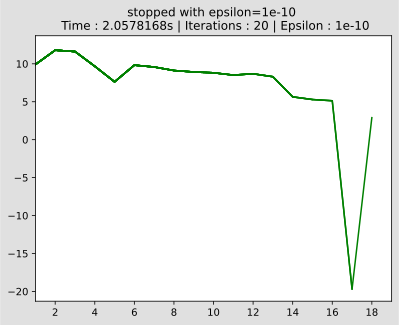

In [21]:
import numpy as np
%matplotlib inline

learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useLocalSearchWithTabuList()

# we could prefere a log2likelihood score
# learner.useScoreLog2Likelihood()
learner.setMaxTime(10)

# representation of the error as a pseudo log (negative values really represents negative epsilon
@np.vectorize
def pseudolog(x):
    res=np.log(x)#np.log(y)

    return res if x>0 else -res

# in order to control the complexity, we limit the number of parents
learner.setMaxIndegree(7) # no more than 3 parent by node
learner.setEpsilon(1e-10)
gnb.animApproximationScheme(learner,
                            scale=pseudolog) # scale by default is np.log10

bn2=learner.learnBN()


## Customizing the learning algorithms

### 1. Learn a tree ?

In [22]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useGreedyHillClimbing()

learner.setMaxIndegree(1) # no more than 1 parent by node
print(learner)
bntree=learner.learnBN()
gnb.sideBySide(bn,bntree,gnb.getBNDiff(bn,bntree),explain.getInformation(bntree),captions=["Original BN","Learned BN","Graphical diff","information"])

Filename                : out/sample_asia.csv
Size                    : (500000,8)
Variables               : visit_to_Asia[2], tuberculosis[2], tuberculos_or_cancer[2], positive_XraY[2], lung_cancer[2], smoking[2], bronchitis[2], dyspnoea[2]
Induced types           : False
Missing values          : False
Algorithm               : Greedy Hill Climbing
Score                   : BDeu
Prior                   : -
Constraint Max InDegree : 1  (Used only for score-based algorithms.)



### 2. with prior structural knowledge

In [23]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useGreedyHillClimbing()

# I know that smoking causes cancer
learner.addMandatoryArc("smoking","lung_cancer") # smoking->lung_cancer
# I know that visit to Asia may change the risk of tuberculosis
learner.addMandatoryArc("visit_to_Asia","tuberculosis") # visit_to_Asia->tuberculosis
print(learner)
bn2=learner.learnBN()
gnb.sideBySide(bn,bn2,gnb.getBNDiff(bn,bn2),explain.getInformation(bn2),captions=["Original BN","Learned BN","Graphical diff","information"])

Filename                  : out/sample_asia.csv
Size                      : (500000,8)
Variables                 : visit_to_Asia[2], tuberculosis[2], tuberculos_or_cancer[2], positive_XraY[2], lung_cancer[2], smoking[2], bronchitis[2], dyspnoea[2]
Induced types             : False
Missing values            : False
Algorithm                 : Greedy Hill Climbing
Score                     : BDeu
Prior                     : -
Constraint Mandatory Arcs : {visit_to_Asia->tuberculosis, smoking->lung_cancer}



### 3. changing the scores

By default, a BDEU score is used. But it can be changed.

In [24]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useGreedyHillClimbing()

# I know that smoking causes cancer
learner.addMandatoryArc(0,1)

# we prefere a log2likelihood score
learner.useScoreLog2Likelihood()

# in order to control the complexity, we limit the number of parents
learner.setMaxIndegree(1) # no more than 1 parent by node
print(learner)
bn2=learner.learnBN()
kl=gum.ExactBNdistance(bn,bn2)
gnb.sideBySide(bn,bn2,gnb.getBNDiff(bn,bn2),
               "<br/>".join(["<b>"+k+"</b> :"+str(v) for k,v in kl.compute().items()]),
               captions=["original","learned BN","diff","distances"])

Filename                  : out/sample_asia.csv
Size                      : (500000,8)
Variables                 : visit_to_Asia[2], tuberculosis[2], tuberculos_or_cancer[2], positive_XraY[2], lung_cancer[2], smoking[2], bronchitis[2], dyspnoea[2]
Induced types             : False
Missing values            : False
Algorithm                 : Greedy Hill Climbing
Score                     : Log2Likelihood
Prior                     : -
Constraint Max InDegree   : 1  (Used only for score-based algorithms.)
Constraint Mandatory Arcs : {visit_to_Asia->tuberculosis}



klPQ :0.149433023607111errorPQ :0klQP :0.05456006909796955errorQP :64hellinger :0.22083396371973207bhattacharya :0.024686022089413118jensen-shannon :0.028351805361282758distances


### 4. comparing BNs
There are multiple ways to compare Bayes net...

In [25]:
help(gnb.getBNDiff)

Help on function getBNDiff in module pyAgrum.lib.notebook:

getBNDiff(bn1, bn2, size=None, noStyle=False)
    get a HTML string representation of a graphical diff between the arcs of _bn1 (reference) with those of _bn2.
    
    if `noStyle` is False use 4 styles (fixed in pyAgrum.config) :
      - the arc is common for both
      - the arc is common but inverted in `bn2`
      - the arc is added in `bn2`
      - the arc is removed in `bn2`
    
    Parameters
    ----------
    bn1: pyAgrum.BayesNet
      the reference
    bn2: pyAgrum.BayesNet
      the compared one
    size: float|str
      size of the rendered graph
    noStyle: bool
      with style or not.
    
    Returns
    -------
      the HTML representation of the comparison



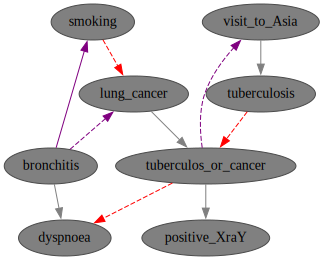

In [26]:
gnb.showBNDiff(bn,bn2)

In [27]:
import pyAgrum.lib.bn_vs_bn as gbnbn
help(gbnbn.graphDiff)

Help on function graphDiff in module pyAgrum.lib.bn_vs_bn:

graphDiff(bnref, bncmp, noStyle=False)
    Return a pydot graph that compares the arcs of bnref to bncmp.
    graphDiff allows bncmp to have less nodes than bnref. (this is not the case in GraphicalBNComparator.dotDiff())
    
    if noStyle is False use 4 styles (fixed in pyAgrum.config) :
      - the arc is common for both
      - the arc is common but inverted in _bn2
      - the arc is added in _bn2
      - the arc is removed in _bn2
    
    See graphDiffLegend() to add a legend to the graph.
    Warning
    -------
    if pydot is not installed, this function just returns None
    
    Returns
    -------
    pydot.Dot
      the result dot graph or None if pydot can not be imported



In [28]:
gbnbn.GraphicalBNComparator?

Init signature: gbnbn.GraphicalBNComparator(name1, name2, delta=1e-06)
Docstring:     
BNGraphicalComparator allows to compare in multiple way 2 BNs...The smallest assumption is that the names of the variables are the same in the 2 BNs. But some comparisons will have also to check the type and domainSize of the variables. The bns have not exactly the  same role : _bn1 is rather the referent model for the comparison whereas _bn2 is the compared one to the referent model.

Parameters
----------
name1 : str or pyAgrum.BayesNet
  a BN or a filename for reference
name2 : str or pyAgrum.BayesNet
  another BN or antoher filename for comparison
File:           c:\users\phw\scoop\apps\python\current\lib\site-packages\pyagrum\lib\bn_vs_bn.py
Type:           type
Subclasses:     


In [29]:
gcmp=gbnbn.GraphicalBNComparator(bn,bn2)
gnb.sideBySide(bn,bn2,gcmp.dotDiff(),gbnbn.graphDiffLegend(),
               bn2,bn,gbnbn.graphDiff(bn2,bn),gbnbn.graphDiffLegend(),
               ncols=4)

G <!-- a --> <!-- b --> <!-- a->b --> a->b overflow <!-- c --> <!-- d --> <!-- c->d --> c->d Missing <!-- e --> <!-- f --> <!-- e->f --> e->f reversed <!-- g --> <!-- h --> <!-- g->h --> g->h Correct
G <!-- a --> <!-- b --> <!-- a->b --> a->b overflow <!-- c --> <!-- d --> <!-- c->d --> c->d Missing <!-- e --> <!-- f --> <!-- e->f --> e->f reversed <!-- g --> <!-- h --> <!-- g->h --> g->h Correct


In [30]:
print("But also gives access to different scores :")
print(gcmp.scores())
print(gcmp.skeletonScores())
print(gcmp.hamming())

But also gives access to different scores :
{'count': {'tp': 4, 'tn': 45, 'fp': 3, 'fn': 4}, 'recall': 0.5, 'precision': 0.5714285714285714, 'fscore': 0.5333333333333333, 'dist2opt': 0.6585388898066349}
{'count': {'tp': 5, 'tn': 18, 'fp': 2, 'fn': 3}, 'recall': 0.625, 'precision': 0.7142857142857143, 'fscore': 0.6666666666666666, 'dist2opt': 0.471442099373003}
{'hamming': 5, 'structural hamming': 8}


In [31]:
print("KL divergence can be computed")
kl=gum.ExactBNdistance (bn,bn2)
kl.compute()

KL divergence can be computed


{'klPQ': 0.149433023607111,
 'errorPQ': 0,
 'klQP': 0.05456006909796955,
 'errorQP': 64,
 'hellinger': 0.22083396371973207,
 'bhattacharya': 0.024686022089413118,
 'jensen-shannon': 0.028351805361282758}

### 5. Mixing algorithms

First we learn a structure with HillClimbing (faster ?)

In [32]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useGreedyHillClimbing()
learner.addMandatoryArc(0,1)
bn2=learner.learnBN()
kl=gum.ExactBNdistance(bn,bn2)
gnb.sideBySide(bn,bn2,gnb.getBNDiff(bn,bn2),
               "<br/>".join(["<b>"+k+"</b> :"+str(v) for k,v in kl.compute().items()]),
               captions=["original","learned BN","diff","distances"])

klPQ :2.47935093496117e-05errorPQ :0klQP :2.1773196505259652e-05errorQP :128hellinger :0.0030111847854838083bhattacharya :4.527985291557084e-06jensen-shannon :6.319472401144876e-06distances


And then we refine with tabuList

In [33]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useLocalSearchWithTabuList()

learner.setInitialDAG(bn2.dag())
print(learner)
bn3=learner.learnBN()
kl=gum.ExactBNdistance(bn,bn3)
gnb.sideBySide(bn,bn2,gnb.getBNDiff(bn,bn2),
               "<br/>".join(["<b>"+k+"</b> :"+str(v) for k,v in kl.compute().items()]),
               captions=["original","learned BN","diff","distances"])

Filename       : out/sample_asia.csv
Size           : (500000,8)
Variables      : visit_to_Asia[2], tuberculosis[2], tuberculos_or_cancer[2], positive_XraY[2], lung_cancer[2], smoking[2], bronchitis[2], dyspnoea[2]
Induced types  : False
Missing values : False
Algorithm      : Local Search with Tabu List
Tabu list size : 2
Score          : BDeu
Prior          : -
Initial DAG    : True  (digraph {
     0;
     1;
     2;
     3;
     4;
     5;
     6;
     7;

     0 -> 1;
     6 -> 5;
     2 -> 1;
     4 -> 1;
     4 -> 5;
     4 -> 2;
     2 -> 6;
     0 -> 2;
     4 -> 6;
     4 -> 7;
     2 -> 3;
     2 -> 7;
     7 -> 6;
}

)



klPQ :1.8792644057031834e-05errorPQ :0klQP :1.577921220664825e-05errorQP :128hellinger :0.0026436422754501612bhattacharya :3.488786460513642e-06jensen-shannon :4.820346591876068e-06distances


## Impact of the size of the database for the learning

In [34]:

rows=3
sizes=[400,500,700,1000,2000,5000,
       10000,50000,75000,
       100000,150000,175000,
       200000,300000,500000]

def extract_asia(n):
    """
    extract n line from asia.csv to extract.csv
    """
    with open("out/sample_asia.csv","r") as src:
        with open("out/extract_asia.csv","w") as dst:
            for _ in range(n+1):
                print(src.readline(),end="",file=dst)

(400,8)
(500,8)
(700,8)
(1000,8)
(2000,8)
(5000,8)
(10000,8)
(50000,8)
(75000,8)
(100000,8)
(150000,8)
(175000,8)
(200000,8)
(300000,8)
(500000,8)


-10.636354694639106


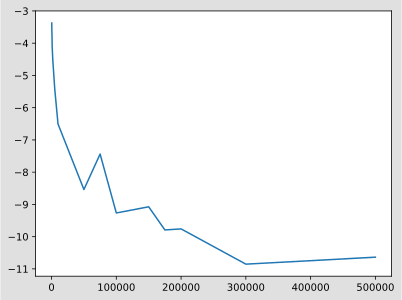

In [35]:
gnb.flow.clear()
nbr=0
l=[]
for i in sizes:
    extract_asia(i)
    learner=gum.BNLearner("out/extract_asia.csv",bn) # using bn as template for variables
    learner.useGreedyHillClimbing()
    print(learner.state()["Size"][0])
    bn2=learner.learnBN()

    kl=gum.ExactBNdistance(bn,bn2)
    r=kl.compute()
    l.append(log(r['klPQ']))

    gnb.flow.add(gnb.getBNDiff(bn,bn2,size='3!'),f"size={i}")

gnb.flow.display()
plot(sizes,l)
print(l[-1])


(400,8)
(500,8)
(700,8)
(1000,8)
(2000,8)
(5000,8)
(10000,8)
(50000,8)
(75000,8)
(100000,8)
(150000,8)
(175000,8)
(200000,8)
(300000,8)
(500000,8)


-10.25257878923374


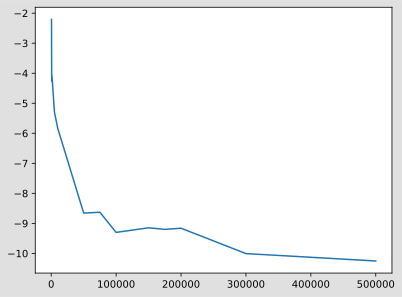

In [36]:
gnb.flow.clear()
nbr=0
l=[]
for i in sizes:
    extract_asia(i)
    learner=gum.BNLearner("out/extract_asia.csv",bn) #using bn as template for variables
    learner.useLocalSearchWithTabuList()
    print(learner.state()["Size"][0])
    bn2=learner.learnBN()

    kl=gum.ExactBNdistance(bn,bn2)
    r=kl.compute()
    l.append(log(r['klPQ']))

    gnb.flow.add(gnb.getBNDiff(bn,bn2,size='3!'),f"size={i}")

gnb.flow.display()
plot(sizes,l)
print(l[-1])